In [1]:
%matplotlib notebook
import os
import sys
import numpy as np
import MulensModel as mm
import scipy.optimize as op
import matplotlib.pyplot as plt

In [2]:
#Loading main files
Mag = np.loadtxt(os.path.join(sys.path[0], 'files/magni.txt'))
Disk = np.loadtxt(os.path.join(sys.path[0], 'files/disk.txt'))
Params = np.loadtxt(os.path.join(sys.path[0], 'files/param.txt'))

In [3]:
mag_file = os.path.join(sys.path[0], 'files/W149.out')

#Adding error bars
def Sigma(mag):
    return 6.51e-09 * np.exp(9.27 * (mag/13.31)**9.35e-01) + 0.001

yerrd = Sigma(Mag[:,-2])
f = np.stack((Mag[:,0], Mag[:,-2], yerrd), axis=-1)
np.savetxt(mag_file, f)

#Building MulensData
mag_data = mm.MulensData(file_name=mag_file)

<IPython.core.display.Javascript object>


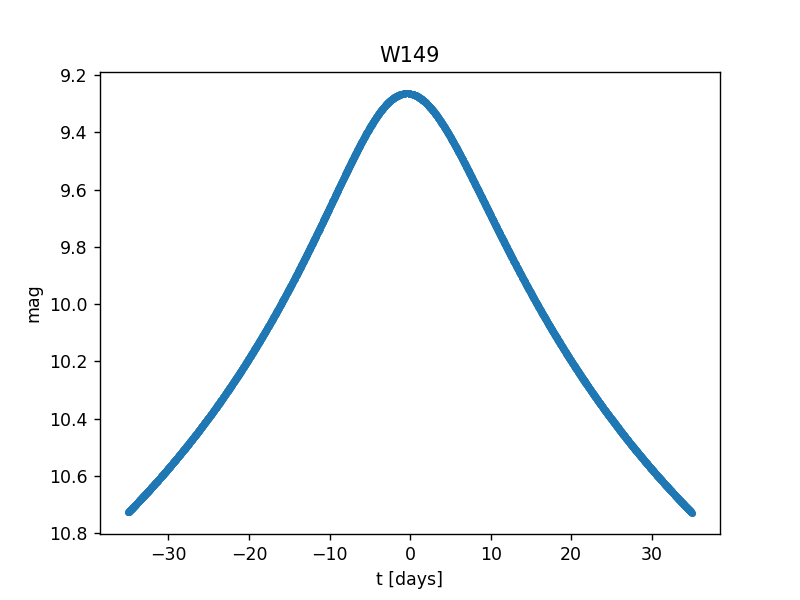

In [4]:
#Plotting data
plt.figure()
plt.title('W149')
plt.errorbar(mag_data.time, mag_data.mag, yerr=mag_data.err_mag, fmt='.')
plt.xlabel('t [days]')
plt.ylabel('mag')
plt.gca().invert_yaxis()
plt.show()

In [5]:
#Building model and event with initial parameters
t0 = 0
u0 = 0.02
tE = 100
dt = 70/3000

pspl_model = mm.Model({'t_0': t0, 'u_0': u0, 't_E': tE})
pspl_model.set_datasets([mag_data])
event = mm.Event(datasets=mag_data, model=pspl_model)
chi2_initial = event.get_chi2()
print("Initial guessed model:\n")
print(event.model.parameters)
print("gives chi^2 of {:.2f}".format(chi2_initial))

Initial guessed model:

    t_0 (HJD)       u_0    t_E (d) 
      0.00000  0.020000   100.0000 

gives chi^2 of 132337131.16


In [6]:
#Fitting
parameters_to_fit = ["t_0", "u_0", "t_E"]
initial_guess = [t0, u0, tE]

def chi2_for_model(theta, event, parameters_to_fit):
    for (key, parameter) in enumerate(parameters_to_fit):
        setattr(event.model.parameters, parameter, theta[key])
    return event.get_chi2()

result = op.minimize(chi2_for_model, x0=initial_guess, args=(event, parameters_to_fit),
                     method='Nelder-Mead', options={'maxiter': 2000})

print("PSPL Model\n")
(fit_t0, fit_u0, fit_tE) = result.x

# Save the best-fit parameters
chi2 = chi2_for_model(result.x, event, parameters_to_fit)

# Output the fit parameters
msg = 'Best Fit: t_0 = {0:.5f}, u_0 = {1:.4f}, t_E = {2:.3f}'
print(msg.format(fit_t0, fit_u0, fit_tE))
print('Chi2 = {0:.2f}'.format(chi2))
print('\nscipy.optimize.minimize result:')
print(result)

PSPL Model

Best Fit: t_0 = -0.18209, u_0 = 0.0338, t_E = 276.543
Chi2 = 55462.71

scipy.optimize.minimize result:
 final_simplex: (array([[-1.82086961e-01,  3.38214413e-02,  2.76542600e+02],
       [-1.82086960e-01,  3.38214330e-02,  2.76542668e+02],
       [-1.82086960e-01,  3.38214370e-02,  2.76542636e+02],
       [-1.82086961e-01,  3.38214377e-02,  2.76542630e+02]]), array([55462.71192958, 55462.71192958, 55462.71192958, 55462.71192958]))
           fun: 55462.711929581594
       message: 'Optimization terminated successfully.'
          nfev: 2080
           nit: 1216
        status: 0
       success: True
             x: array([-1.82086961e-01,  3.38214413e-02,  2.76542600e+02])


<IPython.core.display.Javascript object>


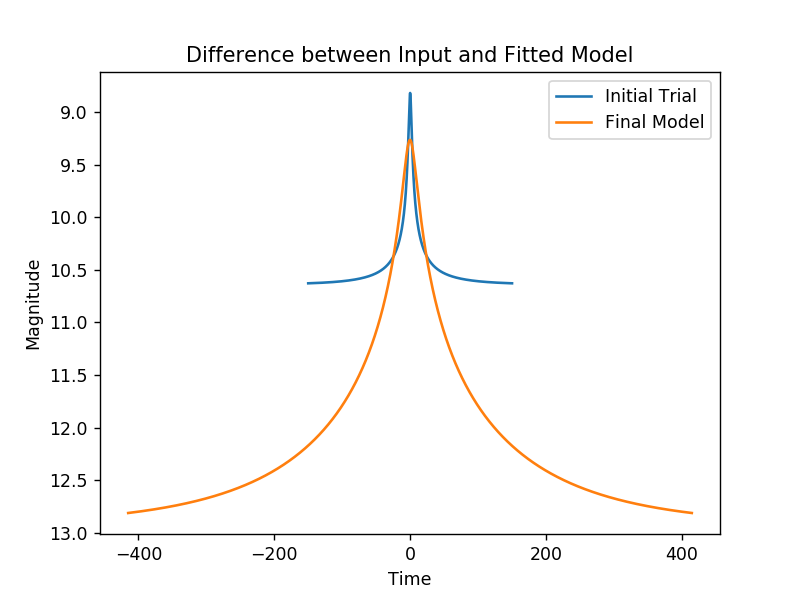

<IPython.core.display.Javascript object>


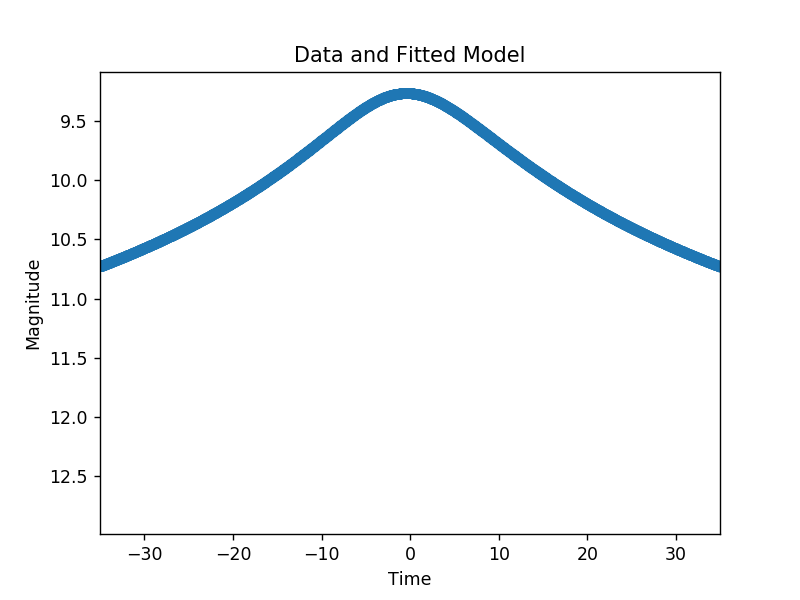

In [7]:
init_model = mm.Model({'t_0': t0, 'u_0': u0, 't_E': tE})
final_model = mm.Model({'t_0': fit_t0, 'u_0': fit_u0, 't_E': fit_tE})
plt.figure()
init_model.plot_lc(data_ref=mag_data, label='Initial Trial', dt=dt)
final_model.plot_lc(data_ref=mag_data, label='Final Model', dt=dt)
plt.title('Difference between Input and Fitted Model')
plt.legend(loc='best')

# Plot the fitted model with the data
plt.figure()
event.plot_data()
event.plot_model(c='red', dt=dt)
plt.title('Data and Fitted Model')

plt.show()

<IPython.core.display.Javascript object>


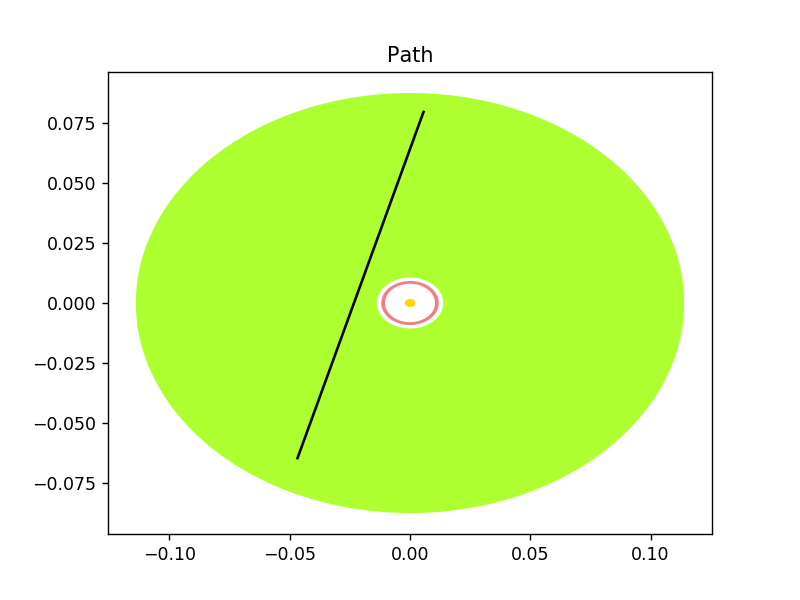

In [8]:
#Path
plt.figure()
plt.title('Path')
plt.fill(Disk[:,8], Disk[:,9], 'greenyellow')
plt.fill(Disk[:,6], Disk[:,7], 'white')
plt.fill(Disk[:,4], Disk[:,5], 'lightcoral')
plt.fill(Disk[:,2], Disk[:,3], 'white')
plt.fill(Disk[:,0], Disk[:,1], 'gold')
plt.plot(Mag[:,1], Mag[:,2], 'k')
plt.gca().set_aspect('equal')
plt.show()